In [1]:
%run init_notebookspace.py
from settings import DATA_DIR, MODEL_DIR

DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\memoire1\data


In [2]:
from config import mod7_params, fred_dict, recession_dict

In [17]:
%matplotlib inline

from gEconpy.classes.model import gEconModel
from gEconpy.classes.transformers import IntervalTransformer
from gEconpy import compile_to_statsmodels
from gEconpy.plotting import plotting as gp


import matplotlib.pyplot as plt
import seaborn as sns
from src.plotting import plot_dfs
from src.gp_plotting import plot_sm_results
from src.process_data import load_data

import numpy as np
import xarray as xr
import pandas as pd

import os
import time

from config import plt_config
plt.rcParams.update(plt_config)

load data

In [4]:
from config import fred_dict

df = load_data('prepro_data.csv', DATA_DIR, fred_dict)
df = df.rename(columns={'pi_s': 'pi_obj'}).drop(['pi_c', 'Ix', 'Zx'], axis=1)
train = df[df['is_test'] == False].drop('is_test', axis=1).copy()
test = df[df['is_test'] == True].drop('is_test', axis=1).copy()

Error occured 'is_test', file_dict may be incomplete


load & solve model

In [5]:
mod = gEconModel(os.path.join(MODEL_DIR, 'gEconpy_mod7_nk.gcn'), verbose=True)

Model Building Complete.
Found:
	25 equations
	25 variables
	The following "variables" were defined as constants and have been substituted away:
		B_t
	5 stochastic shocks
		 0 / 5 has a defined prior. 
	18 parameters
		 0 / 18 has a defined prior. 
	2 calibrating equations
	2 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



In [6]:
# assign parameters
mod.free_param_dict.update(mod7_params)

In [7]:
mod.steady_state()
mod.solve_model()
mod.check_bk_condition();

Steady state found! Sum of squared residuals is 2.3034213894186284e-23
Solution found, sum of squared residuals:  5.233950627320991e-29
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000
Model solution has 14 eigenvalues greater than one in modulus and 11 forward-looking variables.
Blanchard-Kahn condition is satisfied.


#### drawing from priors

In [8]:
from scipy.stats import gamma, norm, beta, uniform
import scipy

In [9]:
def solve_updated_mod(mod, verbose: bool=True):
    
    # solve for steady state
    mod.steady_state(verbose=verbose)
    is_solved = mod.steady_state_solved
    if not is_solved:
        return False, mod
    
    # solve model, capture np.LinAlgEr
    try:
        mod.solve_model(verbose=verbose)
    except np.linalg.LinAlgError:
        return False, mod

    # check blanchard kahn
    is_bk = mod.check_bk_condition(return_value='bool', verbose=verbose)
            
    return is_solved & is_bk, mod

In [10]:
from filterpy.kalman import KalmanFilter
def get_kalman_log_likelihood(observed_vars: list, all_vars: list,
                              measurements: np.array, T: np.array,
                              R_diag: list, ret_all: bool = False):
    
    # outputs
    log_likelihood = []
    mu, cov = None, None
    
    if ret_all:
        mu, cov = [], []
    
    observed_ind = [all_vars.index(item) for item in observed_vars]
    
    # sanity
    # add measurement == observed sanity
    for i in observed_vars:
        assert (i in all_vars) == True, f"{i} not in filter_vars"
        
    
    xdim = len(all_vars)
    zdim = len(observed_vars)
        
    # initialising the Kalman Filter
    kfilter = KalmanFilter(dim_x=xdim, dim_z=zdim)
    kfilter.F = T
    kfilter.R = np.diag(R_diag)
    for i, ind in enumerate(observed_ind):
        kfilter.H[i, ind] = 1
        
    # predict, update, loglike
    for i in measurements:
        kfilter.predict()
        kfilter.update(i)
        
        log_likelihood.append(kfilter.log_likelihood)
        if ret_all:
            mu.append(kfilter.x_post)
            cov.append(kfilter.P_post)
            
    return log_likelihood, mu, cov

In [11]:
def get_arr_pdf_from_dist(dict_vals, dict_dists):
    # Get pdf from distribution for val
    return np.array([dict_dists[item].pdf(dict_vals[item]) for item in dict_vals.keys()])

In [37]:
def printProgBar(iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    perc = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {perc}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()
    pass

In [38]:
test, _, _ = get_kalman_log_likelihood(["Y", 'pi_obj'], 
                                           list(mod.T.columns),
                                           train[["Y", "pi_obj"]].values,
                                           T=mod.T.values,
                                           R_diag=[.01, .01],
                                           ret_all=False)

In [39]:
prior_dist = {
    # 'alpha': beta(1.4, 10),
    # 'beta': beta(.9, 1.5),
    'sigma_C': gamma(a=3.9, loc=0, scale=0.757575757575758),
    'sigma_L': gamma(a=3.9, loc=0, scale=0.757575757575758)
            }

In [40]:
start = time.time()

mod_out = {}
calibration_out = []

# define stepsize of MCMC.
stepsizes = [0.005]  # array of stepsizes
counter = 0.0
n_runs = 10

posterior = {item: [mod7_params[item]] for item in prior_dist.keys()}

# reset params
mod.free_param_dict.update(mod7_params)

for i in range(0, n_runs):
    printProgBar(i, n_runs-1, prefix='Progress')
    
    # old log_likelihood
    old_loglike, _, _ = get_kalman_log_likelihood(["Y", 'pi_obj'], 
                                                   list(mod.T.columns),
                                                   train[["Y", "pi_obj"]].values,
                                                   T=mod.T.values,
                                                   R_diag=[.01, .01],
                                                   ret_all=False)
    old_loglike = sum(old_loglike)

    # draw params from prior & update
    old_prior = {item: vals[-1] for item, vals in posterior.items()}
    new_prior = {k: v for k, v in zip(prior_dist.keys(), [item.rvs() for item in prior_dist.values()])}
    # mod.free_param_dict.update(prior)
    
    # solve model
    is_solved, mod = solve_updated_mod(mod, verbose=False)
    if not is_solved: continue
    
    # new loglikelihood
    new_loglike, _, _ = get_kalman_log_likelihood(["Y", 'pi_obj'], 
                                                   list(mod.T.columns),
                                                   train[["Y", "pi_obj"]].values,
                                                   T=mod.T.values,
                                                   R_diag=[.01, .01],
                                                   ret_all=False)
    new_loglike = sum(new_loglike)
    
    # MH ratio
    ratio = ((new_loglike * get_arr_pdf_from_dist(new_prior, prior_dist)) / (old_loglike * get_arr_pdf_from_dist(old_prior, prior_dist))).mean()
    ω = min([ratio, 1])
    
    random = np.random.uniform(0, 1)
    
    # merge draws prior into posterior 
    if random <= ω:
        is_accepted = True
        counter += 1.
        for key in new_prior.keys():
            posterior[key].append(new_prior[key])
            
    # leave posterior unaltered and restart
    else:
        is_accepted = False
        counter += 0.
    
    
    
    # save output 
    calibration_out.append(
        [
            list(old_prior.values()),
            list(new_prior.values()),
            list(get_arr_pdf_from_dist(new_prior, prior_dist))
        ]
    )
    
    mod_out[i] = dict(
        zip(
            [
                'is_solved',
                'is_accpeted_MH',
                'params',
                'T',
                'R',
                'loglike'
            ],
            [
                is_solved,
                is_accepted,
                mod.free_param_dict,
                mod.T,
                mod.R,
                new_loglike
            ]
        )
    )
        

print(f"\nAcceptance rate = {round(counter/n_runs, 3)}")
print(f'\nExecution time = {round(time.time() - start, 3)} sec')
calibration_out = np.array(calibration_out)

Progress |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 

Acceptance rate = 0.851

Execution time = 367.549 sec


In [42]:
# construct xarray

xarr = xr.Dataset(
    {
        'old_prior': (['draw', 'parameter'], calibration_out[:, 0]),
        'new_prior': (['draw', 'parameter'], calibration_out[:, 1]),
        'new_prior_pdf': (['draw', 'parameter'], calibration_out[:, 2])
        'log_like': (['draw'], 
        
    },
    coords={
        'draw': (['draw'], list(range(0, n_runs))),
        'parameter': (['parameter'], list(prior_dist.keys()))
    },
)
xarr

<xarray.Dataset>
Dimensions:        (draw: 1000, parameter: 2)
Coordinates:
  * draw           (draw) int32 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * parameter      (parameter) <U7 'sigma_C' 'sigma_L'
Data variables:
    old_prior      (draw, parameter) float64 2.0 1.5 3.388 ... 2.9 0.7363 1.224
    new_prior      (draw, parameter) float64 3.388 4.535 2.291 ... 2.444 0.49
    new_prior_pdf  (draw, parameter) float64 0.2191 0.1123 ... 0.2954 0.03687

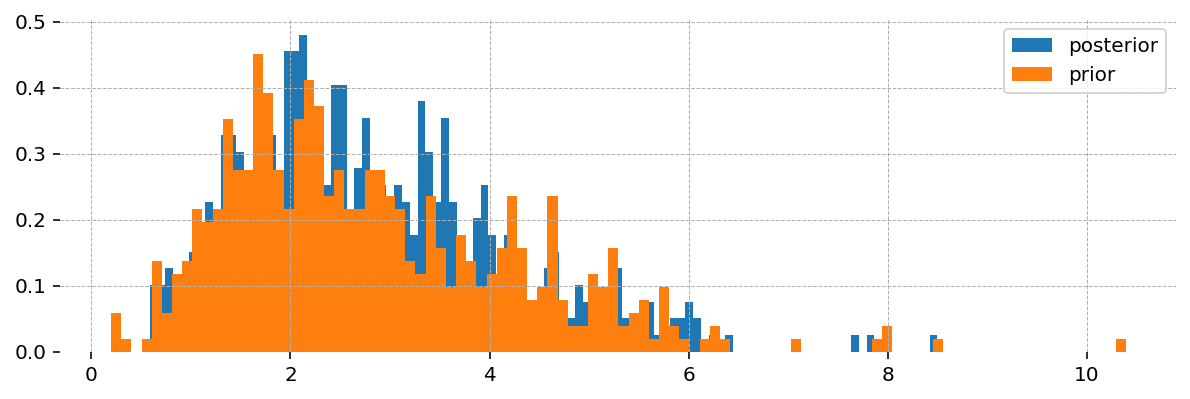

In [45]:
param = 'sigma_C'
bins = int(n_runs/10)
plt.hist(xarr.sel(parameter=param).old_prior[int(n_runs/2):], bins=bins, density=True);
plt.hist([prior_dist[param].rvs() for item in np.linspace(0, 10, int(n_runs/2))], bins=bins, density=True);
plt.legend(['posterior', 'prior'])

save results 

In [36]:
import pickle
import datetime

suffix = f'{datetime.datetime.now().date()}_{datetime.datetime.now().hour}_{datetime.datetime.now().minute}'

xarr.to_netcdf(os.path.join(DATA_DIR, f"posterior_sym_{suffix}.nc"))

f = open(os.path.join(f"mod_sym_{suffix}.pkl"),"wb")
pickle.dump(mod_out,f)
f.close()

## Estimation

In [99]:
no = 2
sample = sample_dict[no].copy()

In [100]:
# filter_vars = list(sample['T'].index[len(sample['T']) - (sample['T'] == 0).sum() != 0])
filter_vars = list(sample['T'].columns)

observed = ["Y", "pi_obj"]
observed_ind = [filter_vars.index(item) for item in observed]

for i in observed:
    assert (i in filter_vars) == True, f"{i} not in filter_vars"
    
xdim = len(filter_vars)
zdim = len(observed)
print(f'xdim: {xdim} \nzdim: {zdim}')

xdim: 25 
zdim: 2


In [101]:
F = sample_dict[no]['T'].loc[filter_vars, filter_vars].values
F.shape

(25, 25)

In [102]:
R = np.eye(zdim) * 0.01
R

array([[0.01, 0.  ],
       [0.  , 0.01]])

In [103]:
kfilter = KalmanFilter(dim_x=xdim, dim_z=zdim)
kfilter.F = F
kfilter.R = R
for i, ind in enumerate(observed_ind):
    kfilter.H[i, ind] = 1
kfilter.H

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [104]:
kfilter.R

array([[0.01, 0.  ],
       [0.  , 0.01]])

In [105]:
mod.R.loc[observed]

,epsilon_R,epsilon_T,epsilon_Y,epsilon_pi,epsilon_preference
Y,-4.252038e+00,-5.809157e-01,5.284028e-01,1.693644,3.108404e-01
pi_obj,-9.811555e-17,-3.005811e-18,2.892069e-17,1.000000,-1.999602e-17


In [106]:
kfilter.Q.shape

(25, 25)

In [107]:
zs = train[observed].values

In [109]:
kfilter.predict()
kfilter.update(zs[0])
kfilter.log_likelihood_of(zs[0])

-3.3787407687578788

In [132]:
mu, cov, _, _ = kfilter.batch_filter(zs)

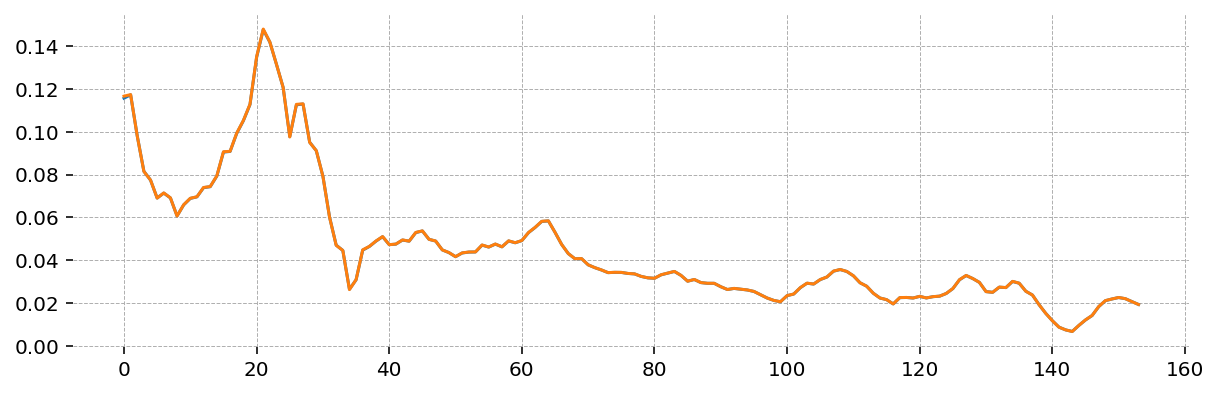

In [133]:
plt.plot(mu.reshape(-1, kfilter.dim_x)[:, 15])
plt.plot(train.pi_obj.values)

In [134]:
mu = pd.DataFrame(mu.reshape(-1,kfilter.dim_x), columns=filter_vars, index=train.index)

In [ ]:
plt.plot(mu.I, label='filter')
plt.plot(train.I, label='data')
plt.legend(['filter', 'data'])